In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import numpy as np
import pandas as pd

import datetime

import re

# import the folium library
try:
    __import__('folium')
except ImportError:
    ! pip install folium

try:
    __import__('branca')
except ImportError:
    ! pip install branca
    
from folium.plugins import TimeSliderChoropleth
import datetime
import json
import urllib.request
from branca.element import Template, MacroElement

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pymc3 as pm
from pymc3 import glm
import statsmodels.api as sm

try:
    __import__('xgboost')
except ImportError:
    ! pip install xgboost  
import arviz as az

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

import math

# Research question 1: 

Has the COVID pandemic caused an increase in the monthly number of highway vehicle miles traveled within the U.S.?


## Data Cleaning for Department of Transportation Stat

In [2]:
df = pd.read_csv("./dataset/Monthly_Transportation_Statistics.csv")

In [3]:
#filter out dates before January 2018 and after January 2022, as this is the data that we will be analyzing.
#The dataset does not record data for the specific column we are looking for before January 2018 or after January 2022.

df['Date'] = pd.to_datetime(df['Date'])
start = "2018-01-01"
end = "2022-01-01"
new_filter = (df['Date'] >= start) & (df['Date'] <= end)
df = df.loc[new_filter]
df

,Index,Date,Air Safety - General Aviation Fatalities,Highway Fatalities Per 100 Million Vehicle Miles Traveled,Highway Fatalities,U.S. Airline Traffic - Total - Seasonally Adjusted,U.S. Airline Traffic - International - Seasonally Adjusted,U.S. Airline Traffic - Domestic - Seasonally Adjusted,Transit Ridership - Other Transit Modes - Adjusted,Transit Ridership - Fixed Route Bus - Adjusted,...,Heavy truck sales SAAR (millions),U.S. Airline Traffic - Total - Non Seasonally Adjusted,Light truck sales SAAR (millions),U.S. Airline Traffic - International - Non Seasonally Adjusted,Auto sales SAAR (millions),U.S. Airline Traffic - Domestic - Non Seasonally Adjusted,Transborder - Total North American Freight,Transborder - U.S. - Mexico Freight,U.S. marketing air carriers on-time performance (percent),Transborder - U.S. - Canada Freight
852,852,2018-01-01,24.0,1.10,8203.0,72470000.0,9070000.0,63400000.0,16028440.0,369920847.0,...,420000.0,64430000.0,11617000.0,8600000.0,5455000.0,55830000.0,9.664831e+10,4.774127e+10,0.8,4.890704e+10
853,853,2018-02-01,25.0,NaN,NaN,73810000.0,9250000.0,64560000.0,15483048.0,364782170.0,...,477000.0,61720000.0,11637000.0,7640000.0,5523000.0,54080000.0,9.396598e+10,4.651254e+10,0.8,4.745345e+10
854,854,2018-03-01,24.0,NaN,NaN,72760000.0,9200000.0,63560000.0,17296690.0,393604986.0,...,482000.0,76290000.0,11756000.0,9650000.0,5323000.0,66640000.0,1.057671e+11,5.186487e+10,0.8,5.390221e+10
855,855,2018-04-01,39.0,1.11,9323.0,74020000.0,9260000.0,64760000.0,17566326.0,392252372.0,...,462000.0,73630000.0,11924000.0,9070000.0,5287000.0,64560000.0,1.026997e+11,5.051882e+10,0.8,5.218090e+10
856,856,2018-05-01,25.0,NaN,NaN,73750000.0,9210000.0,64540000.0,19092459.0,400194774.0,...,478000.0,77300000.0,11809000.0,9450000.0,5389000.0,67840000.0,1.072506e+11,5.212651e+10,0.8,5.512410e+10
857,857,2018-06-01,41.0,NaN,NaN,74370000.0,9240000.0,65140000.0,19026788.0,373053040.0,...,501000.0,80880000.0,11973000.0,10610000.0,5260000.0,70280000.0,1.061642e+11,5.184138e+10,0.8,5.432284e+10
858,858,2018-07-01,36.0,1.18,9934.0,74380000.0,9270000.0,65100000.0,20082435.0,362119816.0,...,493000.0,83960000.0,11789000.0,11420000.0,5220000.0,72540000.0,1.012118e+11,5.093911e+10,0.8,5.027265e+10
859,859,2018-08-01,54.0,NaN,NaN,74400000.0,9270000.0,65130000.0,20702522.0,392397741.0,...,503000.0,80990000.0,11794000.0,10650000.0,5096000.0,70340000.0,1.068971e+11,5.355384e+10,0.8,5.334327e+10
860,860,2018-09-01,29.0,NaN,NaN,74020000.0,9230000.0,64800000.0,17954646.0,385074986.0,...,511000.0,68700000.0,12066000.0,8230000.0,5233000.0,60470000.0,1.016266e+11,5.063414e+10,0.8,5.099241e+10
861,861,2018-10-01,31.0,1.15,9375.0,75060000.0,9420000.0,65640000.0,19367600.0,437208668.0,...,507000.0,75510000.0,12070000.0,8420000.0,5534000.0,67080000.0,1.107956e+11,5.658084e+10,0.8,5.421476e+10


In [4]:
# selecting date and Highway Vehicle Miles Traveled columns and removing the day of each date.

df = df[["Date", "Highway Vehicle Miles Traveled - All Systems"]]
df['Date'] = df['Date'].dt.strftime('%Y-%m')

/tmp/ipykernel_4907/3298539597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].dt.strftime('%Y-%m')


## Data Cleaning for Covid dataset

In [13]:
#covid dataset
df_covid = pd.read_csv("./dataset/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv")

In [14]:
# select date, and new_case

df_covid = df_covid[["submission_date", "new_case"]]

In [15]:
#change format of date

df_covid['submission_date'] = pd.to_datetime(df_covid['submission_date'], errors='coerce')

In [16]:
#adding new column indicating whether a month occurred after the beginning of the pandemic

df['Pandemic Month'] = df['Date'] >= '2020-03'

/tmp/ipykernel_4907/1100700246.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pandemic Month'] = df['Date'] >= '2020-03'


/tmp/ipykernel_4907/1906911518.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60)


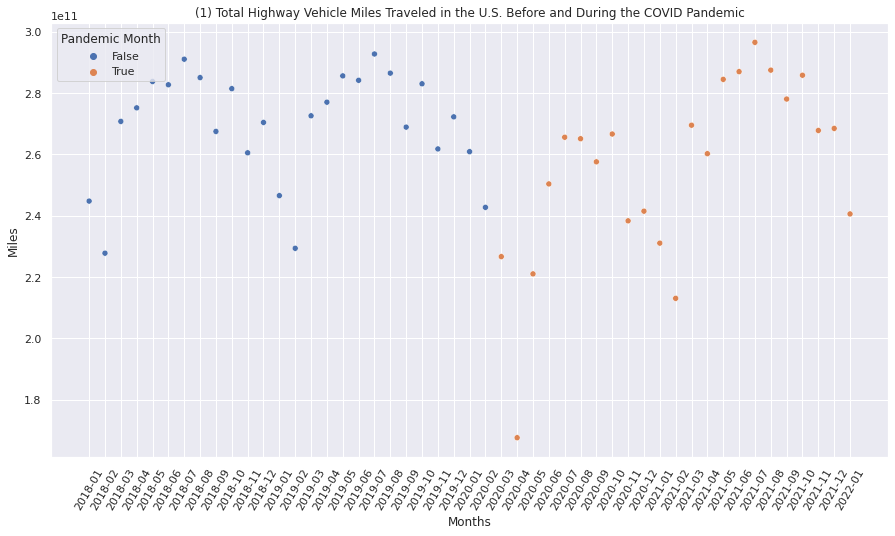

In [17]:
plt.figure(figsize = (15,8))
ax = sns.scatterplot(data=df, x='Date', y='Highway Vehicle Miles Traveled - All Systems', hue='Pandemic Month')
plt.draw()
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.title('(1) Total Highway Vehicle Miles Traveled in the U.S. Before and During the COVID Pandemic')
plt.xlabel('Months')
plt.ylabel('Miles');

In [18]:
#filter out months before the start of the pandemic in df_covid, group by month and aggregate with mean()

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_covid = df_covid.loc[df_covid['submission_date'] >= '2020-03-01']
df_covid['submission_date'] = df_covid['submission_date'].dt.strftime('%m')
df_covid = df_covid.groupby(['submission_date']).mean()
df_covid.reset_index(inplace=True)
df_covid

,submission_date,new_case
0,01,7072.465591
1,02,1809.721429
2,03,529.354659
3,04,709.176749
4,05,441.639516
5,06,348.387778
6,07,892.507527
7,08,1541.467473
8,09,1480.776111
9,10,1177.050538


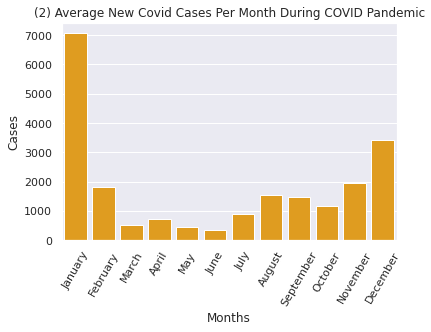

In [19]:
ax = sns.barplot(data=df_covid, x=months, y='new_case', color='orange')
plt.draw()
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.title('(2) Average New Covid Cases Per Month During COVID Pandemic')
plt.xlabel('Months')
plt.ylabel('Cases');

In [20]:
# filter out months before the start of the pandemic in df, group by month, and aggregate with mean()

df = df.loc[df['Pandemic Month'] == True]
df['Date'] = df['Date'].str.slice(start=5, stop=7)
df = df.groupby(['Date']).mean()
df.reset_index(inplace=True)
df

,Date,Highway Vehicle Miles Traveled - All Systems,Pandemic Month
0,01,2.357910e+11,1.0
1,02,2.130380e+11,1.0
2,03,2.480570e+11,1.0
3,04,2.139015e+11,1.0
4,05,2.527060e+11,1.0
5,06,2.686300e+11,1.0
6,07,2.810125e+11,1.0
7,08,2.762410e+11,1.0
8,09,2.677650e+11,1.0
9,10,2.761780e+11,1.0


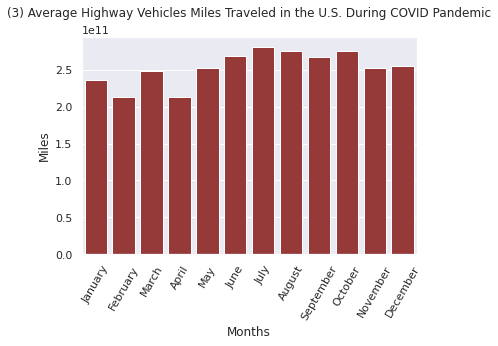

In [21]:
ax = sns.barplot(data=df, x=months, y='Highway Vehicle Miles Traveled - All Systems', color='brown')
plt.draw()
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.title('(3) Average Highway Vehicles Miles Traveled in the U.S. During COVID Pandemic', pad=20)
plt.xlabel('Months')
plt.ylabel('Miles');

## Checkpoint questions

**• Describe any trends you observe, and any relationships you may want to follow up on.**

Plot (1):
The plot shows a clear pattern in total highway miles driven over time for data recorded before the pandemic was officially announced. In particular, the total highway miles driven consistently peaked during the summer months and reached the lowest point during the winter months. However, after March 2020 when the pandemic was officially announced, the total highway miles driven decreased significantly enough in April 2020 to make it an outlier. The peak during the summer also was not as high as in previous years, until 2021. The nonconforming trend in the plot in 2020 is an indication that the COVID pandemic might have caused a change in normal driving behavior on highways, which is what we will be investigating in our causal inference.

Plots (2), (3):
So far, we recognize that there appears to be an inverse trend between the average number of COVID cases per month and the number of vehicle miles traveled per month. This is a promising start for us as we explore the impact COVID had on vehicle miles traveled, however, we have to be wary of confounders such as less travel during winter months. Looking at the scatterplot, we can see that while the parabolas are generally shaped the same and at the same scale, the pandemic months show that the parabola has shifted downwards, which could indicate the pandemic’s effect on vehicle miles traveled. This can also help account for our confounding variables, like the lack of travel during winter months due to the weather, because proportionally the upside down parabolas have the same scale, but are just all shifted equidistantly lower, from what we can infer is the impact of COVID-19.

**• Describe any data cleaning steps you took. How will these decisions impact your models and Inferences?**


For research question one, we decided to use the transportation data set as well as the US COVID database dataset from the CDC. For plot (1), we performed some data cleaning and manipulation steps. First, focusing on the transportation dataset, we felt that it was best to filter out the dates before January 2018 and after January 2022, as there is no data outside of these dates for the column we are looking for: “Highway Vehicle Miles Traveled - All Systems.” We also had to filter the columns to only show the “Highway Vehicle Miles Traveled - All Systems” column. We then removed the day of the dates and added a column named “Pandemic Month” to indicate whether the month occurred during the pandemic. The data was already collected on a monthly basis, which seems optimal for identifying previous trends in highway miles driven and how they changed during the pandemic. Thus, it is best if our units for our causal inference is time in months.

For plot (2), we also had to clean the dataset for our imported COVID dataset. First, we started by selecting the columns we wanted, which were the date and the new cases. After converting the dates into datetime objects, we filtered out data before the beginning of the pandemic, March 2020. We then removed the years and days from the dates and grouped the data by month, aggregating using the mean, giving us the mean number of cases per month of the pandemic. Grouping based on month revealed that winter months were associated with higher case counts on average during the pandemic than the other months. This indicated that winter and school year months could be confounding variables.

For plot (3), we further manipulated the transportation dataset by filtering out months before the pandemic, grouping by month, and aggregating using the mean, giving us the average total highway vehicle miles driven per month of the pandemic. From this we confirmed the confounding variable’s effect on the outcome.

**• Explain how your visualizations should be relevant to your research questions: either by motivating the question, or suggesting a potential answer. You must explain why they are relevant.**

Plot (1):
Plot (1) served as the main motivator for our analysis of the pandemic possibly causing a change in total highway vehicles miles driven in the U.S. Since the scatter plot shows a very clear change in the previous repeating pattern of total highway miles driven over time after the pandemic began, this encourages us to perform causal inference to see whether the pandemic actually caused this change to happen.

Plots (2), (3):
For the graph “Average New Covid Cases Per Month During COVID Pandemic,” we visualized the average number of COVID cases per month for the months of the pandemic using our COVID data. We wanted to check this to show evidence of confounders affecting the outcome. Ultimately, we saw that during the winter months, the average number of new COVID cases per month was higher relative to the summer months. This indicates to us that a month occurring during winter or during the regular school year may be causing the change in new covid cases, which would confirm the confounders’ affect on the treatment.

With our graph “Average Highway Vehicles Miles Traveled in the U.S. During COVID Pandemic,” we are seeking to measure how highway vehicle miles changed throughout the year during the COVID pandemic on a monthly basis. We see that the number of highway miles driven on average peaks in July and then slowly decreases over time. This implies that the confounder may be causing the outcome as well. However, there could be other confounders to this such as better weather in most states and summer break for those in school.

Since the status of a month occurring during winter or during the regular school year is likely a confounding variable based on these plots, it must be accounted for in our causal inference analysis.


## Causal Inference

In [23]:
# Read in the transportation statistics, filter out data before March 2020 and after January 2022, select the
# date and highway vehicle miles traveled columns, and remove the day of the dates
df = pd.read_csv("./dataset/Monthly_Transportation_Statistics.csv")
df['Date'] = pd.to_datetime(df['Date'])
start = "2020-03-01"
end = "2022-01-01"
new_filter = (df['Date'] >= start) & (df['Date'] <= end)
df = df.loc[new_filter]
df = df[["Date", "Highway Vehicle Miles Traveled - All Systems"]]
df['Date'] = df['Date'].dt.strftime('%Y-%m')


In [25]:
# Read in the COVID cases dataset from the CDC, select the date and new case columns, remove the day of the
# dates, and group by month
df_covid = pd.read_csv("./dataset/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv")
df_covid = df_covid[["submission_date", "new_case"]]
df_covid['submission_date'] = pd.to_datetime(df_covid['submission_date'], errors='coerce')
df_covid['submission_date'] = df_covid['submission_date'].dt.strftime('%Y-%m')
df_covid = df_covid.groupby(['submission_date']).sum()
df_covid.reset_index(inplace=True)

In [26]:
# merge df and df_covid based on date, calculate the average number of monthly new cases, create the treatment
# column, create the winter column, and create the school year column.
winter_months = ['12', '01', '02']
school_year = ['09', '10', '11', '12', '01', '02', '03', '04', '05']

df_merged = df.merge(df_covid, how='left', left_on='Date', right_on='submission_date')
avg_num_cases = df_covid.loc[df_covid['submission_date'] >= '2020-03']['new_case'].mean()
df_merged['treatment'] = df_merged['new_case'] >= avg_num_cases
df_merged = df_merged.drop(labels=['submission_date', 'new_case'], axis=1)
months = df_merged['Date'].str.slice(start=5, stop=7)
df_merged['winter'] = months.isin(winter_months)
df_merged['school year'] = months.isin(school_year)
df_merged

,Date,Highway Vehicle Miles Traveled - All Systems,treatment,winter,school year
0,2020-03,2.266380e+11,False,False,True
1,2020-04,1.676170e+11,False,False,True
2,2020-05,2.210060e+11,False,False,True
3,2020-06,2.503300e+11,False,False,False
4,2020-07,2.655500e+11,False,False,False
5,2020-08,2.650600e+11,False,False,False
6,2020-09,2.575310e+11,False,False,True
7,2020-10,2.665960e+11,False,False,True
8,2020-11,2.383000e+11,True,False,True
9,2020-12,2.414510e+11,True,True,True


In [27]:
# function to be used in df_merged.apply() to find matches with the opposite treatment for each row of the
# df_merged and calculate the individual treatment effect
def matching(row):
    opposite_treatment = not row['treatment']
    winter_bool = row['winter']
    school_year = row['school year']
    filtered = df_merged.loc[(df_merged['treatment'] == opposite_treatment) & (df_merged['winter'] == winter_bool) & (df_merged['school year'] == school_year)]
    if opposite_treatment == True:
        return np.mean(df_merged['Highway Vehicle Miles Traveled - All Systems']) - row['Highway Vehicle Miles Traveled - All Systems']
    else:
        return row['Highway Vehicle Miles Traveled - All Systems'] - np.mean(df_merged['Highway Vehicle Miles Traveled - All Systems'])

In [28]:
# adding the individual treatment effect to the df_merged
df_merged['treatment effect'] = df_merged.apply(matching, axis = 1)
df_merged

,Date,Highway Vehicle Miles Traveled - All Systems,treatment,winter,school year,treatment effect
0,2020-03,2.266380e+11,False,False,True,2.855857e+10
1,2020-04,1.676170e+11,False,False,True,8.757957e+10
2,2020-05,2.210060e+11,False,False,True,3.419057e+10
3,2020-06,2.503300e+11,False,False,False,4.866565e+09
4,2020-07,2.655500e+11,False,False,False,-1.035343e+10
5,2020-08,2.650600e+11,False,False,False,-9.863435e+09
6,2020-09,2.575310e+11,False,False,True,-2.334435e+09
7,2020-10,2.665960e+11,False,False,True,-1.139943e+10
8,2020-11,2.383000e+11,True,False,True,-1.689657e+10
9,2020-12,2.414510e+11,True,True,True,-1.374557e+10


In [29]:
# The estimated Average Treatment Effect (in highway miles) based on the data available in df_merged
np.mean(df_merged.apply(matching, axis = 1))

-104604914.9338432

## Results

### Summarize and interpret your results, providing a clear statement about causality (or a lack thereof) including any assumptions necessary.

For our analysis, we filtered out data for months before March 2020, the start of the pandemic, to avoid possible confounders such as the official announcement of the COVID pandemic. Our treated units were months that had an above average number of new COVID cases, while untreated units were months that had below the average number of new COVID cases. In order to test for causality, we used matching causal inference, which was based on two binary confounders: whether a month occurred during winter and whether it occurred during the school year. We were able to calculate the average treatment effect, or ATE, from our model, which resulted in an output of -104,604,914.9 miles. This showed us that for months during the COVID-19 pandemic that had a higher number of cases relative to the average, people in the United States traveled less on highway systems. We mainly made two assumptions in calculating this number. The first one was that people travel less in the winter months given the weather. The second assumption was that people travel less during school months as they do not have as much free time.

### Summarize and interpret your results, providing a clear statement about causality (or a lack thereof) including any assumptions necessary.

One potential uncertainty in our causal inference analysis is that there might not be enough data to make a definitive statement about the average treatment effect of the pandemic on the total number of highway vehicle miles traveled per month. This is mainly due to the fact that we filtered out data for months before March 2020, the start of the COVID pandemic. Another possible uncertainty is that it is possible that there may be additional confounders that may be affecting the result, which would not completely satisfy the unconfoundedness assumption.

# Research Question 2: 

Predicting air carrier fatalities from transit ridership, personal and government construction spending, employment in the industry, using negative binomial regression and decision trees(prediction with GLMs and nonparametric methods).

## Load Data

In [30]:
google_region_report_2020 = pd.read_csv('dataset/2020_US_Region_Mobility_Report.csv')

google_region_report_2021 = pd.read_csv('dataset/2021_US_Region_Mobility_Report.csv')

google_region_report_2022 = pd.read_csv('dataset/2022_US_Region_Mobility_Report.csv')

In [31]:
dot_stat = pd.read_csv('dataset/Monthly_Transportation_Statistics.csv', index_col=[0])

## Data Cleaning for Google region reports data

### 2020

In [32]:
# Metro area
all(np.isnan(google_region_report_2020['metro_area']))
# drop the column, since values are all nan
google_region_report_2020 = google_region_report_2020.drop(columns=['metro_area'])

In [33]:
# iso_3166_2_code
google_region_report_2020['iso_3166_2_code'] = google_region_report_2020['iso_3166_2_code'].replace(np.nan, "")
np.unique(google_region_report_2020['iso_3166_2_code'])
# drop iso_3166_2_code, since already have the info of country, state and county
google_region_report_2020 = google_region_report_2020.drop(columns=['iso_3166_2_code'])

In [34]:
# drop country_region_code, census_fips_code, place_id, and country_region(no need to use)
google_region_report_2020 = google_region_report_2020.drop(columns=['country_region_code', 'country_region', 'census_fips_code', 'place_id'])

In [35]:
# change the dtype of date to datetime
google_region_report_2020['date'] = pd.to_datetime(google_region_report_2020['date'])

In [36]:
# drop all the rows with nan values
google_region_report_2020 = google_region_report_2020[pd.notna(google_region_report_2020).apply(axis=1, func=lambda x: all(x.values))]

In [37]:
google_region_report_2020.rename(columns = {'sub_region_1':'state', 'sub_region_2':'county'}, inplace = True)

In [38]:
# add month and year columm into the df, in order to access data more easily
google_region_report_2020['month'] = google_region_report_2020['date'].apply(lambda x:x.month)

In [39]:
# calculate mean, min, max, and sd of columns by month and state
google_region_report_2020_features = google_region_report_2020.groupby(by=['state', 'month']).agg(['min', 'max', 'mean', lambda x: np.std(x, ddof=0)]).reset_index()

In [40]:
state_2020 = []
month_2020 = []
for state in np.unique(google_region_report_2020['state'].values):
    for i in range(2,13):
        state_2020.append(state)
        month_2020.append(i)

In [41]:
# add state and month columns to google_region_report_2020_features
google_region_report_2020_cleaned = pd.merge(pd.DataFrame({'state': state_2020,
                                                 'month': month_2020
                                                 }), google_region_report_2020_features, how='left', on=['state', 'month'])


/home/zach/miniconda3/envs/DataScience/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [42]:
# drop irrelevant columns 
google_region_report_2020_cleaned  = google_region_report_2020_cleaned.drop(columns = [ ('date', 'min'),
                                                            ('date', 'max'),
                                                           ('date', 'mean'),
                                                     ('date', '<lambda_0>'),])

In [43]:
google_region_report_2020_cleaned[google_region_report_2020_cleaned.isna().any(axis=1)]

,state,month,"(retail_and_recreation_percent_change_from_baseline, min)","(retail_and_recreation_percent_change_from_baseline, max)","(retail_and_recreation_percent_change_from_baseline, mean)","(retail_and_recreation_percent_change_from_baseline, <lambda_0>)","(grocery_and_pharmacy_percent_change_from_baseline, min)","(grocery_and_pharmacy_percent_change_from_baseline, max)","(grocery_and_pharmacy_percent_change_from_baseline, mean)","(grocery_and_pharmacy_percent_change_from_baseline, <lambda_0>)",...,"(transit_stations_percent_change_from_baseline, mean)","(transit_stations_percent_change_from_baseline, <lambda_0>)","(workplaces_percent_change_from_baseline, min)","(workplaces_percent_change_from_baseline, max)","(workplaces_percent_change_from_baseline, mean)","(workplaces_percent_change_from_baseline, <lambda_0>)","(residential_percent_change_from_baseline, min)","(residential_percent_change_from_baseline, max)","(residential_percent_change_from_baseline, mean)","(residential_percent_change_from_baseline, <lambda_0>)"
368,North Dakota,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
june_2020 = google_region_report_2020_cleaned.loc[(google_region_report_2020_cleaned['state'] == 'North Dakota') & (google_region_report_2020_cleaned['month'] == 6)].values

In [45]:
aug_2020 = google_region_report_2020_cleaned.loc[(google_region_report_2020_cleaned['state'] == 'North Dakota') & (google_region_report_2020_cleaned['month'] == 8)].values

In [46]:
# add 2020's July data for North Dakota, by calculating the avg of June and August's data 
google_region_report_2020_cleaned.loc[(google_region_report_2020_cleaned['state'] == 'North Dakota') & (google_region_report_2020_cleaned['month'] == 7)] = ['North Dakota', 7] + ((june_2020[:,2:] + aug_2020[:,2:])/2)[0].tolist()

In [47]:
# check null values again
google_region_report_2020_cleaned[google_region_report_2020_cleaned.isna().any(axis=1)]

,state,month,"(retail_and_recreation_percent_change_from_baseline, min)","(retail_and_recreation_percent_change_from_baseline, max)","(retail_and_recreation_percent_change_from_baseline, mean)","(retail_and_recreation_percent_change_from_baseline, <lambda_0>)","(grocery_and_pharmacy_percent_change_from_baseline, min)","(grocery_and_pharmacy_percent_change_from_baseline, max)","(grocery_and_pharmacy_percent_change_from_baseline, mean)","(grocery_and_pharmacy_percent_change_from_baseline, <lambda_0>)",...,"(transit_stations_percent_change_from_baseline, mean)","(transit_stations_percent_change_from_baseline, <lambda_0>)","(workplaces_percent_change_from_baseline, min)","(workplaces_percent_change_from_baseline, max)","(workplaces_percent_change_from_baseline, mean)","(workplaces_percent_change_from_baseline, <lambda_0>)","(residential_percent_change_from_baseline, min)","(residential_percent_change_from_baseline, max)","(residential_percent_change_from_baseline, mean)","(residential_percent_change_from_baseline, <lambda_0>)"


In [48]:
years_2020 = [2020]*google_region_report_2020_cleaned.shape[0]

In [49]:
# Add year column
google_region_report_2020_cleaned['year'] = years_2020

Complete cleaning for 2020's data.

### 2021

In [50]:
# Metro area
all(np.isnan(google_region_report_2021['metro_area']))
# drop the column, since values are all nan
google_region_report_2021 = google_region_report_2021.drop(columns=['metro_area'])

In [51]:
# iso_3166_2_code
google_region_report_2021['iso_3166_2_code'] = google_region_report_2021['iso_3166_2_code'].replace(np.nan, "")
np.unique(google_region_report_2021['iso_3166_2_code'])
# drop iso_3166_2_code, since already have the info of country, state and county
google_region_report_2021 = google_region_report_2021.drop(columns=['iso_3166_2_code'])

In [52]:
# drop country_region_code, census_fips_code, place_id, and country_region(no need to use)
google_region_report_2021 = google_region_report_2021.drop(columns=['country_region_code', 'country_region', 'census_fips_code', 'place_id'])

In [53]:
# change the dtype of date to datetime
google_region_report_2021['date'] = pd.to_datetime(google_region_report_2021['date'])

In [54]:
# drop all the rows with nan values
google_region_report_2021 = google_region_report_2021[pd.notna(google_region_report_2021).apply(axis=1, func=lambda x: all(x.values))]

In [55]:
google_region_report_2021.rename(columns = {'sub_region_1':'state', 'sub_region_2':'county'}, inplace = True)

In [56]:
# add month and year columm into the df, in order to access data more easily
google_region_report_2021['month'] = google_region_report_2021['date'].apply(lambda x:x.month)

In [57]:
# calculate mean, min, max, and sd of columns by month and state
google_region_report_2021_features = google_region_report_2021.groupby(by=['state', 'month']).agg(['min', 'max', 'mean', lambda x: np.std(x, ddof=0)]).reset_index()

In [58]:
state_2021 = []
month_2021 = []
for state in np.unique(google_region_report_2021['state'].values):
    for i in range(1,13):
        state_2021.append(state)
        month_2021.append(i)

In [59]:
# add state and month columns to google_region_report_2021_features
google_region_report_2021_cleaned = pd.merge(pd.DataFrame({'state': state_2021,
                                                 'month': month_2021,
                                                 }), google_region_report_2021_features, how='left', on=['state', 'month'])

/home/zach/miniconda3/envs/DataScience/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [60]:
# drop irrelevant columns 
google_region_report_2021_cleaned = google_region_report_2021_cleaned.drop(columns = [ ('date', 'min'),
                                                            ('date', 'max'),
                                                           ('date', 'mean'),
                                                     ('date', '<lambda_0>'),])

In [61]:
# check nan values
google_region_report_2021_cleaned[google_region_report_2021_cleaned.isna().any(axis=1)]

,state,month,"(retail_and_recreation_percent_change_from_baseline, min)","(retail_and_recreation_percent_change_from_baseline, max)","(retail_and_recreation_percent_change_from_baseline, mean)","(retail_and_recreation_percent_change_from_baseline, <lambda_0>)","(grocery_and_pharmacy_percent_change_from_baseline, min)","(grocery_and_pharmacy_percent_change_from_baseline, max)","(grocery_and_pharmacy_percent_change_from_baseline, mean)","(grocery_and_pharmacy_percent_change_from_baseline, <lambda_0>)",...,"(transit_stations_percent_change_from_baseline, mean)","(transit_stations_percent_change_from_baseline, <lambda_0>)","(workplaces_percent_change_from_baseline, min)","(workplaces_percent_change_from_baseline, max)","(workplaces_percent_change_from_baseline, mean)","(workplaces_percent_change_from_baseline, <lambda_0>)","(residential_percent_change_from_baseline, min)","(residential_percent_change_from_baseline, max)","(residential_percent_change_from_baseline, mean)","(residential_percent_change_from_baseline, <lambda_0>)"
402,North Dakota,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403,North Dakota,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
# add 2021's August data for North Dakota 
google_region_report_2021_cleaned.loc[(google_region_report_2021_cleaned['state'] == 'North Dakota') & (google_region_report_2021_cleaned['month'] == 8)] = google_region_report_2020_cleaned.loc[(google_region_report_2020_cleaned['state'] == 'North Dakota') & (google_region_report_2020_cleaned['month'] == 8)].values[:,:-1]

In [63]:
google_region_report_2021_cleaned[google_region_report_2021_cleaned.isna().any(axis=1)]

,state,month,"(retail_and_recreation_percent_change_from_baseline, min)","(retail_and_recreation_percent_change_from_baseline, max)","(retail_and_recreation_percent_change_from_baseline, mean)","(retail_and_recreation_percent_change_from_baseline, <lambda_0>)","(grocery_and_pharmacy_percent_change_from_baseline, min)","(grocery_and_pharmacy_percent_change_from_baseline, max)","(grocery_and_pharmacy_percent_change_from_baseline, mean)","(grocery_and_pharmacy_percent_change_from_baseline, <lambda_0>)",...,"(transit_stations_percent_change_from_baseline, mean)","(transit_stations_percent_change_from_baseline, <lambda_0>)","(workplaces_percent_change_from_baseline, min)","(workplaces_percent_change_from_baseline, max)","(workplaces_percent_change_from_baseline, mean)","(workplaces_percent_change_from_baseline, <lambda_0>)","(residential_percent_change_from_baseline, min)","(residential_percent_change_from_baseline, max)","(residential_percent_change_from_baseline, mean)","(residential_percent_change_from_baseline, <lambda_0>)"
402,North Dakota,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
june_2021 = google_region_report_2021_cleaned.loc[(google_region_report_2021_cleaned['state'] == 'North Dakota') & (google_region_report_2021_cleaned['month'] == 6)].values

In [65]:
aug_2021 = google_region_report_2021_cleaned.loc[(google_region_report_2021_cleaned['state'] == 'North Dakota') & (google_region_report_2021_cleaned['month'] == 8)].values

In [66]:
# add 2021's July data for North Dakota, by calculating the avg of June and August's data 
google_region_report_2021_cleaned.loc[(google_region_report_2021_cleaned['state'] == 'North Dakota') & (google_region_report_2021_cleaned['month'] == 7)] = ['North Dakota', 7] + ((june_2021[:,2:] + aug_2021[:,2:])/2)[0].tolist() 

In [67]:
# check null values again
google_region_report_2021_cleaned[google_region_report_2021_cleaned.isna().any(axis=1)]

,state,month,"(retail_and_recreation_percent_change_from_baseline, min)","(retail_and_recreation_percent_change_from_baseline, max)","(retail_and_recreation_percent_change_from_baseline, mean)","(retail_and_recreation_percent_change_from_baseline, <lambda_0>)","(grocery_and_pharmacy_percent_change_from_baseline, min)","(grocery_and_pharmacy_percent_change_from_baseline, max)","(grocery_and_pharmacy_percent_change_from_baseline, mean)","(grocery_and_pharmacy_percent_change_from_baseline, <lambda_0>)",...,"(transit_stations_percent_change_from_baseline, mean)","(transit_stations_percent_change_from_baseline, <lambda_0>)","(workplaces_percent_change_from_baseline, min)","(workplaces_percent_change_from_baseline, max)","(workplaces_percent_change_from_baseline, mean)","(workplaces_percent_change_from_baseline, <lambda_0>)","(residential_percent_change_from_baseline, min)","(residential_percent_change_from_baseline, max)","(residential_percent_change_from_baseline, mean)","(residential_percent_change_from_baseline, <lambda_0>)"


In [68]:
years_2021 = [2021]*google_region_report_2021_cleaned.shape[0]

In [69]:
google_region_report_2021_cleaned['year'] = years_2021

Complete cleaning for 2021's data.

### 2022

In [70]:
# Metro area
all(np.isnan(google_region_report_2022['metro_area']))
# drop the column, since values are all nan
google_region_report_2022 = google_region_report_2022.drop(columns=['metro_area'])

In [71]:
# iso_3166_2_code
google_region_report_2022['iso_3166_2_code'] = google_region_report_2022['iso_3166_2_code'].replace(np.nan, "")
np.unique(google_region_report_2022['iso_3166_2_code'])
# drop iso_3166_2_code, since already have the info of country, state and county
google_region_report_2022 = google_region_report_2022.drop(columns=['iso_3166_2_code'])

In [72]:
# drop country_region_code, census_fips_code, place_id, and country_region(no need to use)
google_region_report_2022 = google_region_report_2022.drop(columns=['country_region_code', 'country_region', 'census_fips_code', 'place_id'])

In [73]:
# change the dtype of date to datetime
google_region_report_2022['date'] = pd.to_datetime(google_region_report_2022['date'])

In [74]:
# drop all the rows with nan values
google_region_report_2022 = google_region_report_2022[pd.notna(google_region_report_2022).apply(axis=1, func=lambda x: all(x.values))]

In [75]:
google_region_report_2022.rename(columns = {'sub_region_1':'state', 'sub_region_2':'county'}, inplace = True)

In [76]:
# add month columm into the df, in order to access data more easily
google_region_report_2022['month'] = google_region_report_2022['date'].apply(lambda x:x.month)

In [77]:
# calculate mean, min, max, and sd of columns by month and state
google_region_report_2022_features = google_region_report_2022.groupby(by=['state', 'month']).agg(['min', 'max', 'mean', lambda x: np.std(x, ddof=0)]).reset_index()

In [78]:
state_2022 = []
month_2022 = []
for state in np.unique(google_region_report_2022['state'].values):
    for i in range(1,5):
        state_2022.append(state)
        month_2022.append(i)

In [79]:
# add state and month columns to google_region_report_2022_features
google_region_report_2022_cleaned = pd.merge(pd.DataFrame({'state': state_2022,
                                                 'month': month_2022,
                                                 }), google_region_report_2022_features, how='left', on=['state', 'month'])

/home/zach/miniconda3/envs/DataScience/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [80]:
# drop irrelevant columns
google_region_report_2022_cleaned = google_region_report_2022_cleaned.drop(columns = [ ('date', 'min'),
                                                            ('date', 'max'),
                                                           ('date', 'mean'),
                                                     ('date', '<lambda_0>'),])

In [81]:
# check null values again
google_region_report_2022_cleaned[google_region_report_2022_cleaned.isna().any(axis=1)]

,state,month,"(retail_and_recreation_percent_change_from_baseline, min)","(retail_and_recreation_percent_change_from_baseline, max)","(retail_and_recreation_percent_change_from_baseline, mean)","(retail_and_recreation_percent_change_from_baseline, <lambda_0>)","(grocery_and_pharmacy_percent_change_from_baseline, min)","(grocery_and_pharmacy_percent_change_from_baseline, max)","(grocery_and_pharmacy_percent_change_from_baseline, mean)","(grocery_and_pharmacy_percent_change_from_baseline, <lambda_0>)",...,"(transit_stations_percent_change_from_baseline, mean)","(transit_stations_percent_change_from_baseline, <lambda_0>)","(workplaces_percent_change_from_baseline, min)","(workplaces_percent_change_from_baseline, max)","(workplaces_percent_change_from_baseline, mean)","(workplaces_percent_change_from_baseline, <lambda_0>)","(residential_percent_change_from_baseline, min)","(residential_percent_change_from_baseline, max)","(residential_percent_change_from_baseline, mean)","(residential_percent_change_from_baseline, <lambda_0>)"


In [82]:
years_2022 = [2022]*google_region_report_2022_cleaned.shape[0]

In [83]:
# add "year" column
google_region_report_2022_cleaned['year'] = years_2022

No need to further clean 2022's data, since no county is missing any data in any month.

### 2020-2022

In [84]:
# combine 2020-2022 cleaned data into one dataframe
google_region_report_all_years = pd.concat([google_region_report_2020_cleaned, google_region_report_2021_cleaned, google_region_report_2022_cleaned])

## Data Cleaning for Department of Transportation Stat

In [85]:
# transform date field to pandas datetime field
dot_stat['Date'] = pd.to_datetime(dot_stat['Date'])

In [86]:
# select data range from Feb 2020 to now
dot_stat = dot_stat[dot_stat['Date'] >= min(google_region_report_2020['date']) - datetime.timedelta(days=15)]

In [87]:
# drop columns that contains only NaN
columns_to_drop = []
for column in dot_stat.columns:
    if all(np.isnan(dot_stat[column])):
        columns_to_drop.append(column)

In [88]:
# search for columns that contains information that may help predict air safety
air_related_columns = ['Date']
for column in dot_stat.columns:
    if 'Air' in column or 'air' in column or 'Runway' in column or 'Public Safety' in column or 'Infrastructure' in column or 'Unemploy' in column or 'Labor' in column:
        air_related_columns.append(column)

In [89]:
air_stat = dot_stat[air_related_columns].reset_index().drop(columns=['Index'])

In [90]:
# fill na values with average of previous 3 values (in quarter)
def fill_na_previous_average(df, col_name):
    while df[col_name].isna().any():
        first_na = df[col_name].isna().diff() & df[col_name].isna()
        seven_average = df.rolling(3, min_periods=1).mean().shift()[col_name]
        df.loc[first_na, col_name] = seven_average
        
for column in air_stat.columns:
    fill_na_previous_average(air_stat, column)

In [91]:
# We are still in April, the data for fatalities is not concluded
air_stat.at[26, 'Air Safety - General Aviation Fatalities'] = np.nan

In [92]:
# add season feature
def get_season(d, Y):
    seasons = [('winter', (datetime.date(Y,  1,  1),  datetime.date(Y,  3, 20))),
           ('spring', (datetime.date(Y,  3, 21),  datetime.date(Y,  6, 20))),
           ('summer', (datetime.date(Y,  6, 21),  datetime.date(Y,  9, 22))),
           ('autumn', (datetime.date(Y,  9, 23),  datetime.date(Y, 12, 20))),
           ('winter', (datetime.date(Y, 12, 21),  datetime.date(Y, 12, 31)))]

    return next(season for season, (start, end) in seasons
                if start <= d <= end)

air_stat['season'] = air_stat['Date'].apply(lambda x: get_season(x, x.year))

## Visualization 

### % change with respect to state and time

In [93]:
# extract all mean cols
google_report_all_years_mean_cols = [col for col in google_region_report_all_years.columns if 'mean' in col]
# extract the greatest mean % change location in terms of abs value
great_change = abs(google_region_report_all_years[google_report_all_years_mean_cols]).idxmax(axis=1).apply(lambda x:re.match("[^\_][a-z]+", x[0])[0])
google_region_report_all_years['greatest_%_change_location'] = great_change

In [94]:
# check the labels for places with greatest % change(result: no residential/grocerty and pharmacy) 
np.unique(great_change) 

array(['parks', 'retail', 'transit', 'workplaces'], dtype=object)

In [95]:
# get the geography data
state_geo = json.load(open('us-states.json'))

In [96]:
def state_style(state, year, month, function=False):
    
    data = google_region_report_all_years[(google_region_report_all_years['state'] == state) & (google_region_report_all_years['month'] == month) & (google_region_report_all_years['year'] == year)]
    state_result = data['greatest_%_change_location'].values[0]
    
    #Set state colour
    if state_result == 'parks':
        color = '#a9c5a1'
    elif state_result == 'retail':
        color = '#e5b284'
    elif state_result == 'transit':
        color = '#887e76'
    elif state_result == 'workplaces':
        color = '#a1b0ef'
    
    #Set state style
    if function == False:
        # Format for style_dictionary
        state_style = {
            'opacity': 0.7,
            'color': color,
        } 
    else:
        # Format for style_function
        state_style = {
             'fillOpacity': 0.7,
             'weight': 1,
             'fillColor': color,
             'color': '#000000'
        }
    return state_style

In [97]:
def style_function(feature):
    """
    style_function used by the GeoJson folium function
    """

    state = feature['properties']['name']
    style = state_style(state, month = 2, year = 2021,function=True)
    return style

In [98]:
def time_to_ts(year, month):
    """
    convert time for time slider
    """
    time = datetime.datetime(year, month, 1, 0, 0).strftime('%s')
    if len(time)==9: time ='0{}'.format(time)
    return time

In [99]:
def style_dictionary():
    """
    style_dictionary used by the TimeSliderChoropleth folium function
    """
    
    # get ids used by TimeSliderChoropleth
    ID = {}

    for state in state_geo['features']:
        state_id = state['id']
        state_name = state['properties']['name']
        ID[state_name] = state_id
    
    
    #create style dictionary
    style_dic= {}
    for state in np.unique(google_region_report_all_years['state']):
        
        state_dic = {}
        for year in range(2020,2023):
            for month in range(1, 13):
                if (year == 2020 and month == 1) or (year == 2022 and month > 4):
                    continue
                else:
                    time = time_to_ts(year, month)
                    state_dic[time] =  state_style(state,year,month)

        style_dic[ID[state]] = state_dic  
        
    return style_dic

In [100]:
# define the template for map styles
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Categories of places</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#a9c5a1;'></span>Parks</li>
    <li><span style='background:#e5b284;'></span>Retail</li>
    <li><span style='background:#887e76;'></span>Transit</li>
    <li><span style='background:#a1b0ef;'></span>Workspaces</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

In [101]:
# initialize the map and store it in a m object
loc = 'Largest change in movement trends across different states over time'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)  

m = folium.Map(location=[35.77500, -100],zoom_start=3,width='65%',height='65%')

choropleth = TimeSliderChoropleth(data=state_geo, styledict=style_dictionary())

m.add_child(choropleth)

m.get_root().add_child(macro)

m.get_root().html.add_child(folium.Element(title_html))

m

### General aviation Fatalities with respect to season

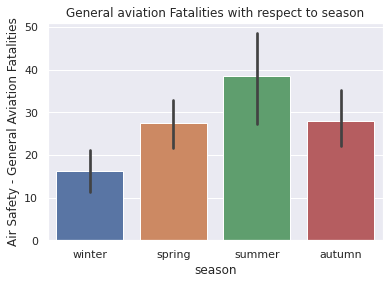

In [102]:
ax = sns.barplot(x="season", y="Air Safety - General Aviation Fatalities",data=air_stat).set(title='General aviation Fatalities with respect to season')

## Checkpoint questions:



**• Visualize at least two quantitative variables and two categorical variables. Your visualizations
must be relevant to your research questions!**

The "% change with respect to state and time" plot shows the change categorical variable "Categories of places" with time from Feb 2021 to April 2022. This visualization would help us understand which category of places experiencing the most drstical % change(in absolute value) for each state in US by month. "Categories of places" could be used as a feature in the prediction model of air carrier fatilities.

By visualizing the value we want to predict with respect to season, a feature that contains more information than the raw dataset is provided, we are hoping to discover whether season is a meaningful feature engineering step.

**• Describe any trends you observe, and any relationships you may want to follow up on.**

Geoplot(largest change in movement trends across different states over time):

We notice that the residential and grocery_and_pharmacy percent change from baseline are not experiencing drastical changes. It's reasonable because people always need residential areas, grocery and pharmacy to live, no matter where they are.
For Janunary 2021, the % change of transit in most of the state is the greatest in absolute value.

Barplot(season vs fatility): 

From the graph, we can tell that fatalities in aviation have a higher value in summer comparing to all other three seasons, while it is the lowest during the winter. Although the value being lowest should be related to the time COVID-19 broke out, which was prior to 2020 spring.

**• Describe any data cleaning steps you took. How will these decisions impact your models and inferences?**

For the google region reports data, we first identify the nan values, which is mainly the data for North Dakota July 2020, July 2021, and August 2021. We remove the nan vlaues by filling the nan values of August 2021 by the data of August 2020. Also, we use the average of June and August data to fill the July data.

For the DOT transportation data, we limit the dataset to the same span of time the google region reports data provides, and fill the nan value with an average value of the data 3 months prior to the nan value entry. The filling procedure may heavily impact data from 2022, since there are a lot of columns being nan, and the intrinsic value of these columns are often decided by policies, domestic or international events, which means they often cannot be accurately portrayed by an average.

**• Explain how your visualizations should be relevant to your research questions: either by motivating the question, or suggesting a potential answer. You must explain why they are relevant.**

Since the prediction model requires the transit ridership as a feature, we would like to investigate in the movement trends over time by geography, across different categories of places such as retail and recreation, groceries and pharmacies, parks, transit stations, workplaces, and residential. The different movement trends may affect the fatility in the air travel.

From the dot dataset, we are only provided with so much information. Extracting seasonality out of date is to suggest the possibility of externalities with respect to these given data: Is there a trend of maintenence employment or working pressure that cannot be reflected directly by our given dataset, but might be partially captured by our extracted features?


## Load data

In [103]:
dot = pd.read_csv('dataset/dot_df.csv')
google = pd.read_csv('dataset/google_df.csv')

## Feature Engineering

In [104]:
for column in google.columns:
    matches = re.findall("'(.+)'\, '(.+)'", column)
    if len(matches) == 0:
        continue
    else:
        matches = list(matches[0])
        if '<lambda_0>' in matches:
            matches[1] = 'std'
        matches.insert(1, '_')
        google.rename(columns={column: ''.join(matches)}, inplace=True)

In [105]:
google = pd.concat([google, pd.get_dummies(google['greatest_%_change_location'])], axis=1)

In [106]:
dictionary = {}
for state in np.unique(google['state']):
    for column in google.columns:
        if 'percent_change' in column:
            dictionary[state+"_"+column] = google[google['state'] == state][column].values

In [107]:
dot = pd.concat([dot, pd.get_dummies(dot['season'])], axis=1)

In [108]:
data = pd.concat([dot, pd.DataFrame(data=dictionary)], axis=1)

<AxesSubplot:xlabel='Date'>

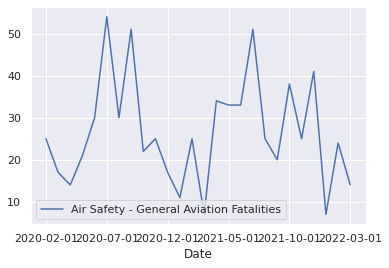

In [109]:
data.plot('Date', 'Air Safety - General Aviation Fatalities')

## Feature selection

In [110]:
fatalities_columns = [column for column in data.columns if ('Fatalities' in column) and ('General' not in column)]

In [111]:
data.iloc[:, 2:20].corr()

,U.S. Airline Traffic - Total - Seasonally Adjusted,U.S. Airline Traffic - International - Seasonally Adjusted,U.S. Airline Traffic - Domestic - Seasonally Adjusted,State and Local Government Construction Spending - Runway,State and Local Government Construction Spending - Air Passenger Terminal,State and Local Government Construction Spending - Air,State and Local Government Construction Spending - Other Public Safety,State and Local Government Construction Spending - Public Safety,State and Local Government Construction Spending - Infrastructure,Transportation Employment - Air Transportation,Unemployment Rate - Seasonally Adjusted,Labor Force Participation Rate - Seasonally Adjusted,Unemployed - Seasonally Adjusted,Air Safety - Air Taxi and Commuter Fatalities,Air Safety - Air Carrier Fatalities,U.S. Air Carrier Cargo (millions of revenue ton-miles) - International,U.S. Air Carrier Cargo (millions of revenue ton-miles) - Domestic,U.S. Airline Traffic - Total - Non Seasonally Adjusted
U.S. Airline Traffic - Total - Seasonally Adjusted,1.000000,0.968413,0.999471,-0.303851,-0.677861,-0.527555,-0.507865,-0.700842,-0.624025,0.871348,-0.891203,0.715658,-0.894053,0.178647,NaN,0.456264,0.288219,0.985756
U.S. Airline Traffic - International - Seasonally Adjusted,0.968413,1.000000,0.959789,-0.461478,-0.724358,-0.633476,-0.527298,-0.706920,-0.636605,0.896814,-0.887097,0.772057,-0.890939,0.176496,NaN,0.323515,0.205527,0.929731
U.S. Airline Traffic - Domestic - Seasonally Adjusted,0.999471,0.959789,1.000000,-0.281838,-0.668642,-0.511265,-0.502996,-0.696817,-0.619502,0.863976,-0.887616,0.704960,-0.890323,0.178130,NaN,0.471479,0.297705,0.988486
State and Local Government Construction Spending - Runway,-0.303851,-0.461478,-0.281838,1.000000,0.731361,0.923708,0.570579,0.593529,0.427416,-0.413303,0.408722,-0.363868,0.412393,0.120194,NaN,-0.022908,0.033144,-0.229788
State and Local Government Construction Spending - Air Passenger Terminal,-0.677861,-0.724358,-0.668642,0.731361,1.000000,0.935693,0.843072,0.936059,0.829734,-0.662713,0.701950,-0.449152,0.704765,-0.014818,NaN,-0.461037,-0.356811,-0.621959
State and Local Government Construction Spending - Air,-0.527555,-0.633476,-0.511265,0.923708,0.935693,1.000000,0.759899,0.826289,0.674786,-0.569467,0.595691,-0.425971,0.599203,0.048277,NaN,-0.267100,-0.174344,-0.458666
State and Local Government Construction Spending - Other Public Safety,-0.507865,-0.527298,-0.502996,0.570579,0.843072,0.759899,1.000000,0.933392,0.801074,-0.518106,0.583960,-0.413081,0.581751,0.064933,NaN,-0.459839,-0.532675,-0.470198
State and Local Government Construction Spending - Public Safety,-0.700842,-0.706920,-0.696817,0.593529,0.936059,0.826289,0.933392,1.000000,0.860545,-0.661986,0.758337,-0.477635,0.758664,0.018930,NaN,-0.600093,-0.545548,-0.670709
State and Local Government Construction Spending - Infrastructure,-0.624025,-0.636605,-0.619502,0.427416,0.829734,0.674786,0.801074,0.860545,1.000000,-0.676929,0.608181,-0.354101,0.609724,0.045830,NaN,-0.531599,-0.563861,-0.572422
Transportation Employment - Air Transportation,0.871348,0.896814,0.863976,-0.413303,-0.662713,-0.569467,-0.518106,-0.661986,-0.676929,1.000000,-0.777135,0.701370,-0.781607,0.083773,NaN,0.275678,0.214181,0.851431


In [112]:
traffic = [column for column in data.columns if ('Airline Traffic' in column)][1:]

data.drop(columns=['Date'] + traffic + fatalities_columns + ['season'], inplace=True)
data.drop(columns=['Unemployed - Seasonally Adjusted'], inplace=True)

In [113]:
data.isna().all().all()

False

## Negative Binomial regression

In [151]:
train, test = data.iloc[:len(data) - 1], pd.DataFrame(data.iloc[len(data) - 1, :]).T

### Bayesian

In [115]:
columns_dict = {}
for column in train.iloc[:, :14].columns:
    columns_dict[column] = "".join([string[0] for string in re.findall('\w+', column)])

In [116]:
train_bayesian = train.iloc[:, :14].rename(columns=columns_dict)

In [117]:
test_bayesian = test.rename(columns=columns_dict)

In [118]:
start_dict = {}
for column in train_bayesian.iloc[:, 1:].columns:
    start_dict[column] = 0

In [119]:
with pm.Model() as negbin_model_b:
    glm.GLM.from_formula('ASGAF ~ USATTSA+SaLGCSR+SaLGCSAPT+SaLGCSA+SaLGCSOPS+SaLGCSPS+SaLGCSI+TEAT+URSA+LFPRSA+USACCmortmI+USACCmortmD+USmacotpp', train_bayesian, family=glm.families.NegativeBinomial())
    # draw posterior samples using NUTS sampling
    negbin_trace = pm.sample(1000, start=start_dict, target_accept=0.95, random_seed=23)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, mu, USmacotpp, USACCmortmD, USACCmortmI, LFPRSA, URSA, TEAT, SaLGCSI, SaLGCSPS, SaLGCSOPS, SaLGCSA, SaLGCSAPT, SaLGCSR, USATTSA, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 371 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8758698468261853, but should be close to 0.95. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [120]:
with negbin_model_b:
    negbin_ppc = pm.sample_posterior_predictive(
        negbin_trace, var_names=list(start_dict.keys()) + ["Intercept", "y"]
    )

In [121]:
pred = 0
for column in list(start_dict.keys()):
    pred += np.outer(negbin_ppc[column], train_bayesian[column].values)
y_hat_negbin = np.ceil(np.exp(pred + negbin_ppc["Intercept"][:,np.newaxis]))

In [122]:
test_pred = 0
for column in list(start_dict.keys()):
    test_pred += np.outer(negbin_ppc[column], test_bayesian[column].values)
y_test_pred = np.ceil(np.exp(test_pred + negbin_ppc["Intercept"][:,np.newaxis]))

### Frequentist

In [123]:
train_freq = pd.concat([pd.DataFrame(data=np.ones(train.shape[0])), train.iloc[:, 1:14]], axis=1)
train_freq.rename(columns={0:'Const'}, inplace=True)

In [124]:
test_freq = pd.concat([pd.Series(np.ones(test.shape[0])), test.iloc[:, 1:14].reset_index(drop=True)], axis=1)
test_freq.rename(columns={0:'Const'}, inplace=True)

In [125]:
negbin_model = sm.GLM(
    train['Air Safety - General Aviation Fatalities'], train_freq,
    family=sm.families.NegativeBinomial()
)
negbin_results = negbin_model.fit()
print(negbin_results.summary())

                            Generalized Linear Model Regression Results                             
Dep. Variable:     Air Safety - General Aviation Fatalities   No. Observations:                   26
Model:                                                  GLM   Df Residuals:                       12
Model Family:                              NegativeBinomial   Df Model:                           13
Link Function:                                          Log   Scale:                          1.0000
Method:                                                IRLS   Log-Likelihood:                -110.65
Date:                                      Mon, 09 May 2022   Deviance:                       3.7134
Time:                                              17:13:03   Pearson chi2:                     3.41
No. Iterations:                                          10   Pseudo R-squ. (CS):            0.08996
Covariance Type:                                  nonrobust                                

In [127]:
def negbin(x, y): 
    model = sm.GLM(
        y, x,
        family=sm.families.Poisson()
    )
    results = model.fit()
    params = results.params
    
    return params

def bootstrap(X, y, fnc, w=None, B=1000, plot=True):
    d = X.shape[1]
    N = X.shape[0]
    w_hat = fnc(X, y)
    w_boot = np.zeros(shape=(B,d))
    np.random.seed(59)
    for b in range(B):
        bootstrap_indices = np.random.choice(np.arange(N), N)
        bootstrap_X = X.iloc[bootstrap_indices, :]
        bootstrap_y = y.iloc[bootstrap_indices]
        w_boot[b,:] = fnc(bootstrap_X, bootstrap_y)
    return w_boot

In [128]:
result = bootstrap(train_freq, train.iloc[:, 0], negbin, 4000)

In [129]:
for i, column in enumerate(pd.concat([pd.DataFrame(data=np.ones(train.shape[0])), train.iloc[:, 1:14]], axis=1).columns):
    print(f"Bootstrap std error for {column}: {result.std(axis = 0)[i]:.3f}")

Bootstrap std error for 0: 180.401
Bootstrap std error for U.S. Airline Traffic - Total - Seasonally Adjusted: 0.000
Bootstrap std error for State and Local Government Construction Spending - Runway: 0.000
Bootstrap std error for State and Local Government Construction Spending - Air Passenger Terminal: 0.000
Bootstrap std error for State and Local Government Construction Spending - Air: 0.000
Bootstrap std error for State and Local Government Construction Spending - Other Public Safety: 0.000
Bootstrap std error for State and Local Government Construction Spending - Public Safety: 0.000
Bootstrap std error for State and Local Government Construction Spending - Infrastructure: 0.000
Bootstrap std error for Transportation Employment - Air Transportation: 0.000
Bootstrap std error for Unemployment Rate - Seasonally Adjusted: 100.408
Bootstrap std error for Labor Force Participation Rate - Seasonally Adjusted: 292.984
Bootstrap std error for U.S. Air Carrier Cargo (millions of revenue ton

## Train test split

In [130]:
tscv = TimeSeriesSplit(n_splits=8,test_size=2)

In [131]:
for train_index, validation_index in tscv.split(train.index):
    
    train_X, train_y = train.loc[train_index].iloc[:, 1:], train.loc[train_index].iloc[:, 0]
    
    val_X, val_y = train.loc[validation_index].iloc[:, 1:], train.loc[validation_index].iloc[:, 0]
    
    lgb = xgboost.XGBRegressor(base_score=30)
    lgb.fit(train_X, train_y)
    
    print('for split ', train_index, validation_index)
    print('mae for training is', mean_absolute_error(train_y, lgb.predict(train_X)))
    print('mae for validation is', mean_absolute_error(val_y, lgb.predict(val_X)))
    print('\n')

for split  [0 1 2 3 4 5 6 7 8 9] [10 11]
mae for training is 0.00032100677490234377
mae for validation is 36.99964141845703


for split  [ 0  1  2  3  4  5  6  7  8  9 10 11] [12 13]
mae for training is 0.00029079119364420575
mae for validation is 11.404361248016357


for split  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] [14 15]
mae for training is 0.00025994437081473213
mae for validation is 16.330257415771484


for split  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [16 17]
mae for training is 0.00024139881134033203
mae for validation is 8.992023468017578


for split  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] [18 19]
mae for training is 0.0002491209242078993
mae for validation is 28.3597469329834


for split  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [20 21]
mae for training is 0.0002180337905883789
mae for validation is 10.880334854125977


for split  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] [22 23]
mae for training 

## XGBoost

In [152]:
train_np, val_np = train.iloc[:len(train)-2, :], pd.DataFrame(train.iloc[len(train)-2:, :])

In [153]:
train_X, train_y = train_np.iloc[:, 1:], train_np.iloc[:, 0]
val_X, val_y = val_np.iloc[:, 1:], val_np.iloc[:, 0]
test_X = test.iloc[:, 1:]

In [154]:
xgb_grid = {'booster': ['gbtree', 'dart'],
            'max_depth': range(3, 15),
           'min_child_weight': range(1, 9),
            'gamma': np.linspace(0, 0.1, 10)}

In [155]:
xgb_random = xgboost.XGBRegressor(base_score=30, n_jobs=-1, tree_method='hist')

xgb_random = RandomizedSearchCV(estimator = xgb_random,
                                 param_distributions = xgb_grid,
                                 verbose=1, n_jobs = -1, n_iter=50, cv=6, random_state=22,
                                scoring='neg_mean_squared_error', return_train_score=True)
# Fit the random search model
xgb_random.fit(train_X, train_y)

Fitting 6 folds for each of 50 candidates, totalling 300 fits


RandomizedSearchCV(cv=6,
                   estimator=XGBRegressor(base_score=30, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=No...
                                          validate_parameters=None,
                                          verbosity=None),
                   n_iter=50, n_jobs=-1,
                   para

In [156]:
xgb_random.best_estimator_.colsample_bylevel = 0.8
xgb_random.best_estimator_.colsample_bytree = 0.8
xgb_random.best_estimator_.subsample = 0.8
xgb_random.best_estimator_.reg_alpha = 20
xgb_random.best_estimator_.learning_rate= 0.05
xgb_random.best_estimator_.n_estimators= 1000
xgb_best = xgb_random.best_estimator_

In [157]:
xgb_best.fit(train_X, train_y)

XGBRegressor(base_score=30, booster='dart', colsample_bylevel=0.8,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0.08888888888888889, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=8, min_child_weight=8, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=20, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='hist', validate_parameters=1, verbosity=None)

In [158]:
mean_absolute_error(train_y, np.ceil(xgb_best.predict(train_X)))

2.3333333333333335

In [159]:
mean_absolute_error(val_y, np.ceil(xgb_best.predict(val_X)))

6.5

In [160]:
np.ceil(xgb_best.predict(test_X))

array([26.], dtype=float32)

## Results

### Summarize and interpret the results from your models

- For GLM in Bayesian implementation, by plotting the distribution of the mean absolution error calculated between predicting over the training set by sampling from posterior and the ground truth, we can observe that majority of the errors we obtain is ranging from 7.5 to roughly 20. By plotting the distribution of the prediction on the test set by sampling from posterior, we can obtain a 95% probability credible interval that our prediction will fall between 11 and 36.
- For GLM in Frequentist implementation, we can see that by the standard of log-likelood, our model is not a good fit. By Chi-square test, our model is quite okay in fitting the data. Our negative binomial model has a mean absolute error of 7.8076923076923075. over the training set, and predict that on the test set, the value of fatilities will be 18.
- For non-parametric method, we choose XGBoost's implementation of decision tree. We split the first 24 months of data into training set, the following 2 months of data into validation set, and the final month as test set. On training set, we achieved a mean absolute error of 2.3333333333333335, and on validation set, we achieved a mean absolute error of 6.5. On test, we predict the value of fatalities will be 26.

### Estimate any uncertainty in your GLM predictions, providing clear quantitative statements of the uncertainty in plain English.

- For GLM in Bayesian implementation, we can see from the posterior predictive checks that for any of the features that we used, none of them are very confident in terms of being a variable over the training set.

- For GLM in Frequentist implementation, we confirm the uncertainty of our fit by comparing those with the result of bootstraping, which in nature should be less confident than our fitting results.

### GLM in Bayesian implementation

In [167]:
columns_dict = {v: k for k, v in columns_dict.items()}

Posterior predictive checks for each feature


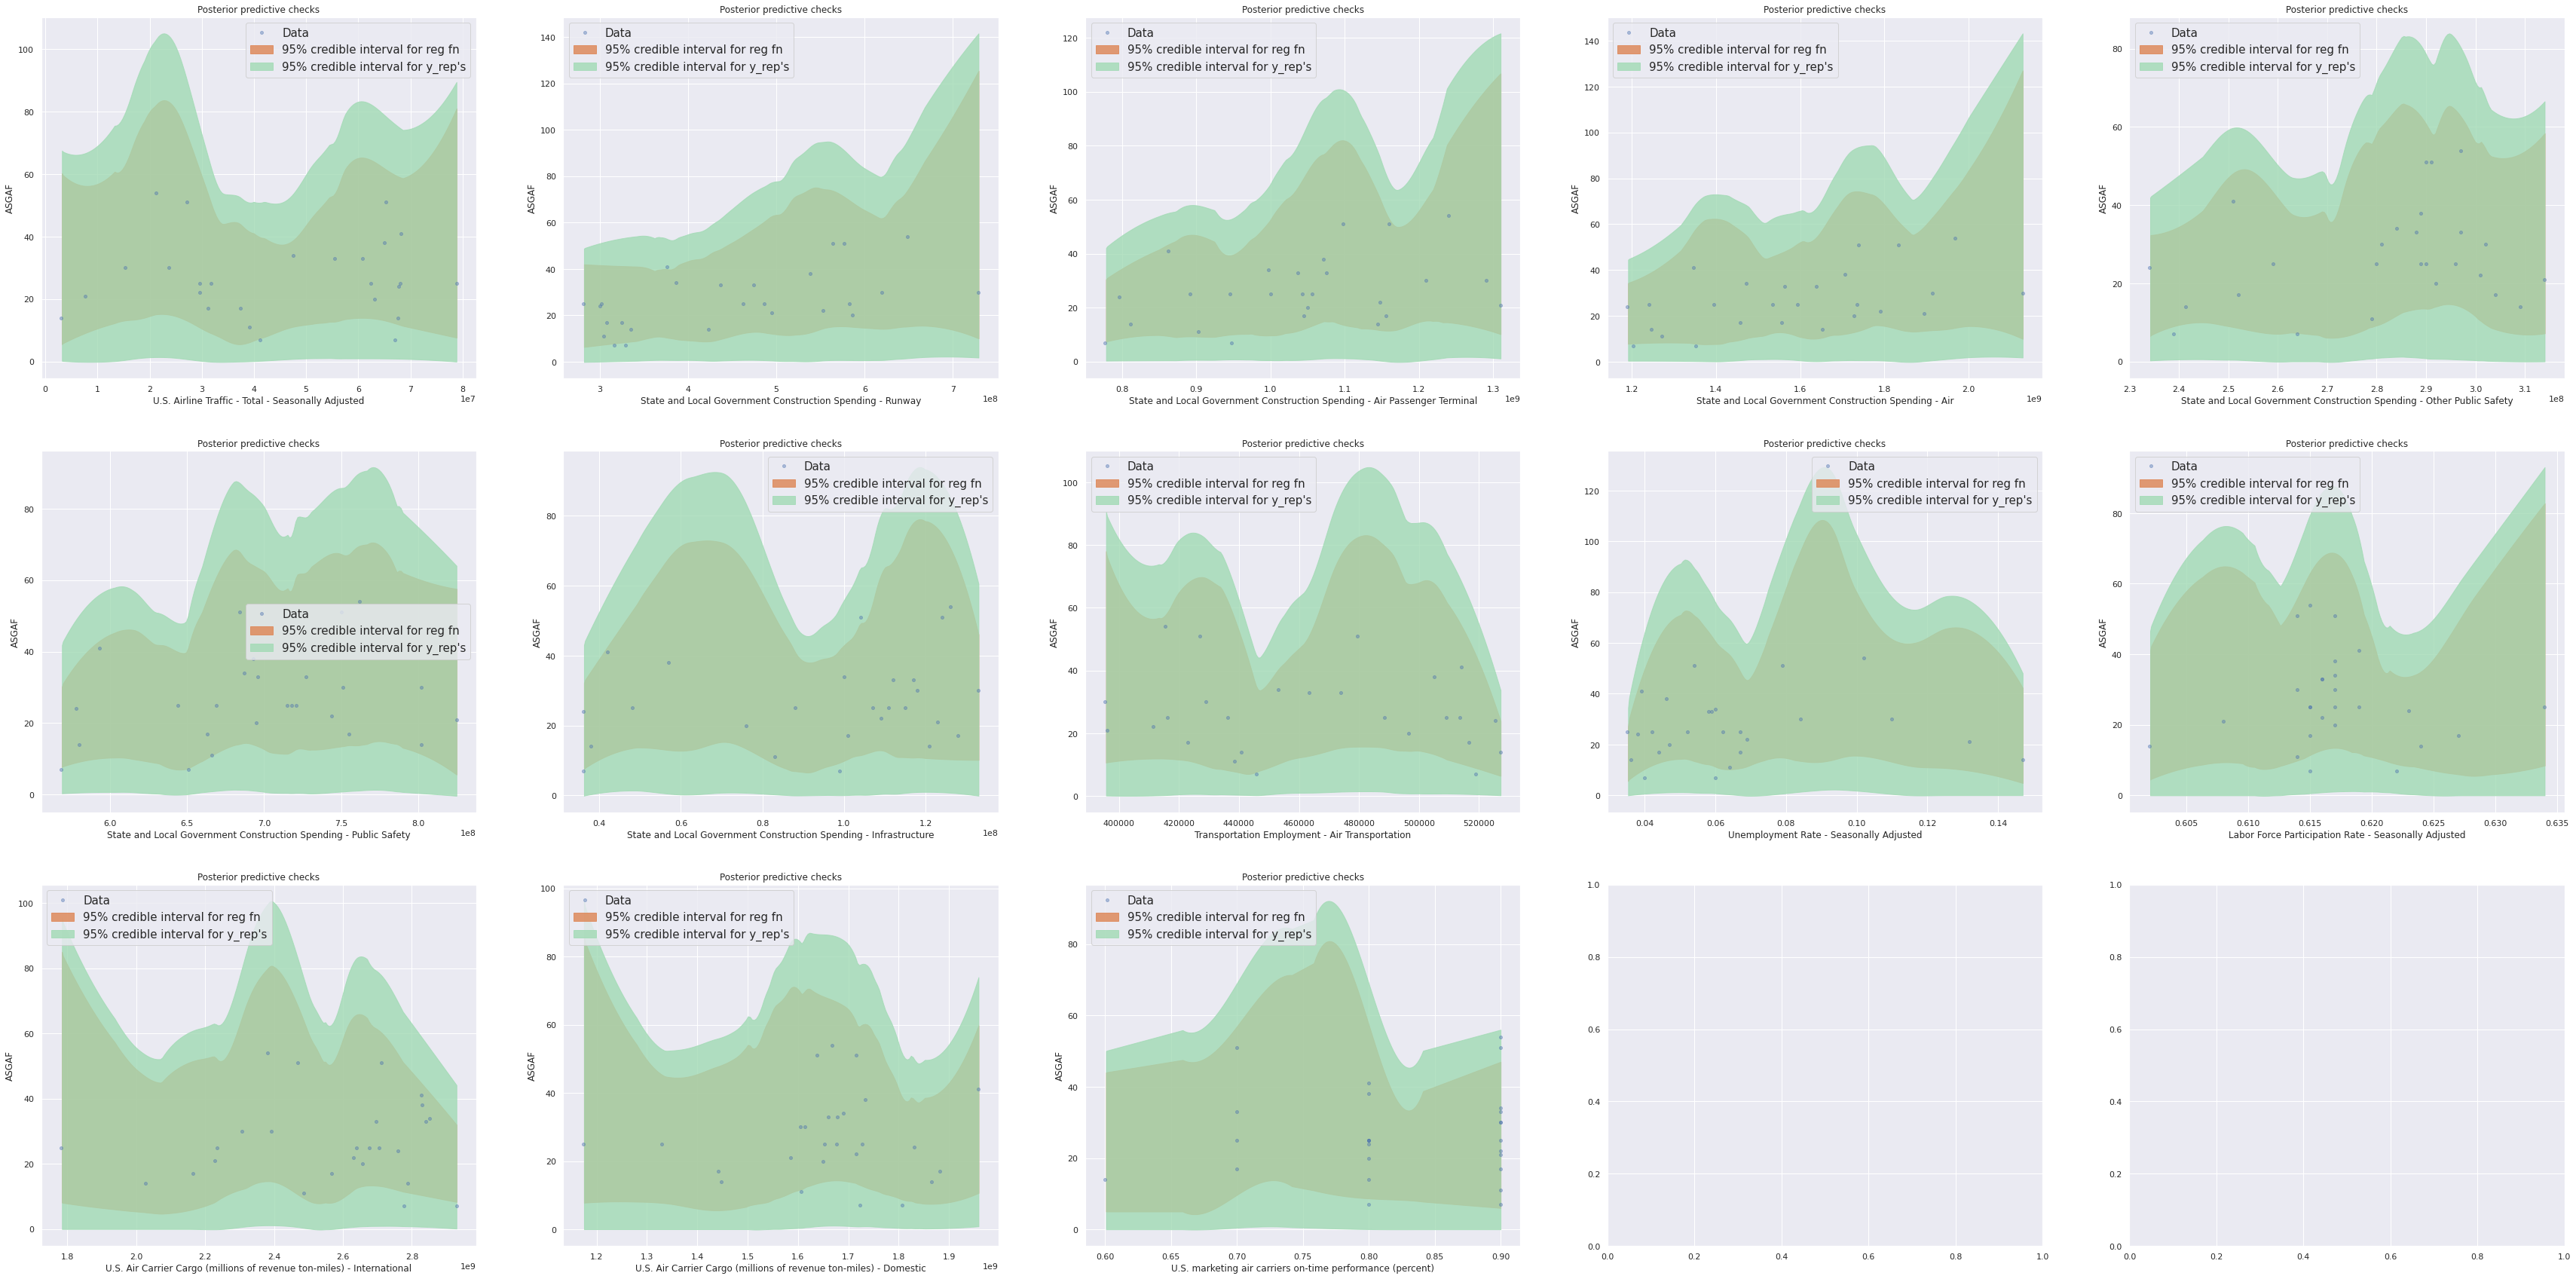

In [168]:
bayesian_ppc, ax = plt.subplots(3, 5, figsize = (60, 30))

for i, column in enumerate(list(start_dict.keys())):
    ax[i//5][i%5].plot(train_bayesian[column], train_bayesian.ASGAF, "o", ms=4, alpha=0.4, label="Data")
    az.plot_hdi(
        train_bayesian[column],
        y_hat_negbin,
        ax=ax[i//5][i%5],
        hdi_prob=0.95,
        fill_kwargs={"alpha": 0.8, "label": "95% credible interval for reg fn"},
    )
    az.plot_hdi(
        train_bayesian[column],
        negbin_ppc['y'],
        ax=ax[i//5][i%5],
        hdi_prob=0.95,
        fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "95% credible interval for y_rep's"},
    )

    ax[i//5][i%5].set_xlabel(columns_dict[column])
    ax[i//5][i%5].set_ylabel("ASGAF")
    ax[i//5][i%5].set_title("Posterior predictive checks")
    ax[i//5][i%5].legend(fontsize=15);
print("Posterior predictive checks for each feature")

Text(0.5, 1.0, 'mean absolute error of Bayesian Negative Binomial sampling from posterior on training set')

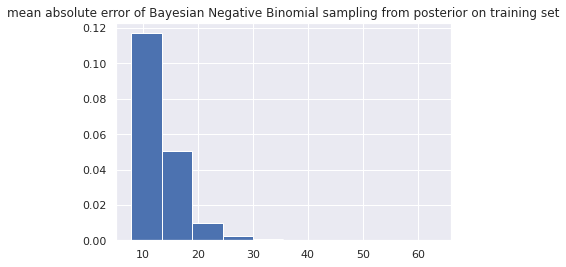

In [169]:
plt.hist([mean_absolute_error(train_bayesian.ASGAF, pred) for pred in y_hat_negbin], density=True)
plt.title('mean absolute error of Bayesian Negative Binomial sampling from posterior on training set')

Credible interval with probability of 0.95: P(11.0 < Fatalities < 36.0) = 0.95


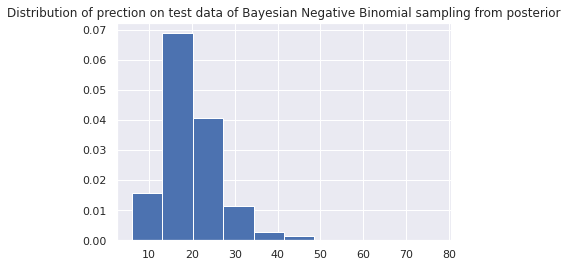

In [170]:
plt.hist(y_test_pred, density=True)
plt.title('Distribution of prection on test data of Bayesian Negative Binomial sampling from posterior')
print("Credible interval with probability of 0.95: P({} < Fatalities < {}) = 0.95".format(np.percentile(y_test_pred, 2.5), np.percentile(y_test_pred, 97.5)))

### GLM in frequentist implementation

In [171]:
print(negbin_results.summary())

                            Generalized Linear Model Regression Results                             
Dep. Variable:     Air Safety - General Aviation Fatalities   No. Observations:                   26
Model:                                                  GLM   Df Residuals:                       12
Model Family:                              NegativeBinomial   Df Model:                           13
Link Function:                                          Log   Scale:                          1.0000
Method:                                                IRLS   Log-Likelihood:                -110.65
Date:                                      Mon, 09 May 2022   Deviance:                       3.7134
Time:                                              17:52:19   Pearson chi2:                     3.41
No. Iterations:                                          10   Pseudo R-squ. (CS):            0.08996
Covariance Type:                                  nonrobust                                

In [172]:
for i, column in enumerate(train_freq.columns):
    print(f"Bootstrap std error for {column}: {result.std(axis = 0)[i]:.10f}")

Bootstrap std error for Const: 180.4005909402
Bootstrap std error for U.S. Airline Traffic - Total - Seasonally Adjusted: 0.0000001763
Bootstrap std error for State and Local Government Construction Spending - Runway: 0.0000000975
Bootstrap std error for State and Local Government Construction Spending - Air Passenger Terminal: 0.0000000995
Bootstrap std error for State and Local Government Construction Spending - Air: 0.0000000959
Bootstrap std error for State and Local Government Construction Spending - Other Public Safety: 0.0000001134
Bootstrap std error for State and Local Government Construction Spending - Public Safety: 0.0000000600
Bootstrap std error for State and Local Government Construction Spending - Infrastructure: 0.0000000718
Bootstrap std error for Transportation Employment - Air Transportation: 0.0000822217
Bootstrap std error for Unemployment Rate - Seasonally Adjusted: 100.4082772110
Bootstrap std error for Labor Force Participation Rate - Seasonally Adjusted: 292.9

In [173]:
mean_absolute_error(train.iloc[:, 0], np.ceil(negbin_results.predict(train_freq[negbin_model.exog_names].values, linear=False)))

7.8076923076923075

In [174]:
np.ceil(negbin_results.predict(test_freq[negbin_model.exog_names].values[0], linear=False))

array([18.])

### Non-parametric methods: XGBoost

In [175]:
mean_absolute_error(train_y, np.ceil(xgb_best.predict(train_X)))

2.3333333333333335

In [176]:
mean_absolute_error(val_y, np.ceil(xgb_best.predict(val_X)))

6.5

In [177]:
np.ceil(xgb_best.predict(test_X))

array([26.], dtype=float32)